In [106]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import svd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.covariance import LedoitWolf, EmpiricalCovariance, MinCovDet
import time
import pandas as pd

In [159]:
corr = np.array([
    [1, 0.62, 0.76],
    [0.62, 1, 0.87],
    [0.76, 0.87, 1]
])
vol = np.array([0.15, 0.18, 0.21])
var = vol ** 2
mu = np.array([0.2, 0.5, -0.07])
df = 25
n_data = 2000

In [5]:
var

array([0.0225, 0.0324, 0.0441])

In [6]:
s = np.outer(var, var) * corr

In [7]:
s

array([[0.00050625, 0.00045198, 0.00075411],
       [0.00045198, 0.00104976, 0.00124309],
       [0.00075411, 0.00124309, 0.00194481]])

In [8]:
# This is an experiment for how precise the MLE covariance is
# Conclusion: there's quite variability in sampling

In [9]:
def get_sampling_error(estimator, mu, s, n_trials=1000, n_data=5000, dist='normal', df=None):

    distance = []
    cov_gen = []
    
    
    for i in range(n_trials):
#         if i % 100 == 0:
#             print(np.round(i/n_trials,3))
        if dist == 'normal':
            data = stats.multivariate_normal.rvs(mean=mu, cov=s, size=n_data)
        elif dist == 't':
            data = stats.multivariate_t.rvs(loc=mu, shape=s, size=n_data, df=df)
        else:
            raise Exception('method can be either normal or t')
        cov = estimator(data)
        cov_gen.append(cov)
        mae = np.sum(np.abs((cov - s) / s))
        distance.append(mae)
        
    return distance, cov_gen

In [11]:
mle = lambda x: np.cov(x.T)
distance_mle, cov_gen_mle = get_sampling_error(mle, mu, s, dist='t', df=20)
ledoit_wolf = lambda x: LedoitWolf().fit(x).covariance_
distance_lw, cov_gen_lw = get_sampling_error(ledoit_wolf, mu, s, dist='t', df=20)
min_cov_det = lambda x: MinCovDet().fit(x).covariance_
distance_mcd, cov_gen_mcd = get_sampling_error(ledoit_wolf, mu, s, dist='t', df=20)


In [41]:
s

array([[0.00050625, 0.00045198, 0.00075411],
       [0.00045198, 0.00104976, 0.00124309],
       [0.00075411, 0.00124309, 0.00194481]])

In [42]:
cov_gen_mle[np.argmin(distance_mle)]

array([[0.00053302, 0.00045941, 0.0007761 ],
       [0.00045941, 0.00111074, 0.00129843],
       [0.0007761 , 0.00129843, 0.00204103]])

In [43]:
cov_gen_lw[np.argmin(distance_lw)]

array([[0.00053179, 0.00045862, 0.00077082],
       [0.00045862, 0.00108848, 0.00127655],
       [0.00077082, 0.00127655, 0.00202248]])

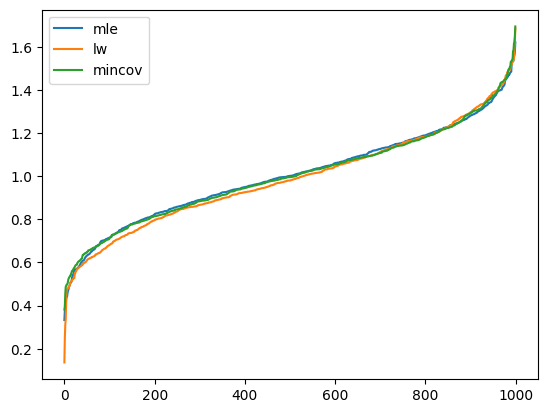

In [12]:
plt.plot(np.sort(distance_mle), label='mle')
plt.plot(np.sort(distance_lw), label='lw')
plt.plot(np.sort(distance_mcd), label='mincov')
plt.legend()
plt.show()

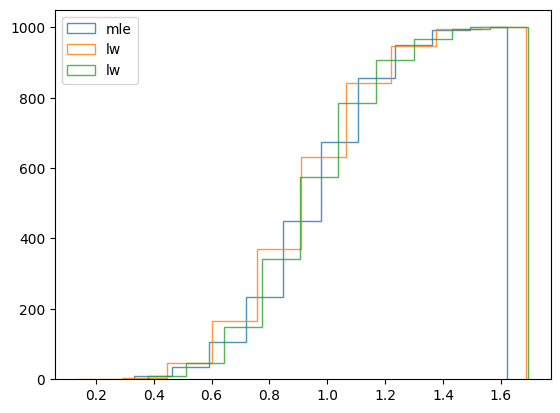

In [13]:
plt.hist(distance_mle,cumulative=True, label='mle',
         histtype='step', alpha=0.8)
plt.hist(distance_lw,cumulative=True, label='lw',
         histtype='step', alpha=0.8)
plt.hist(distance_mcd,cumulative=True, label='lw',
         histtype='step', alpha=0.8)
plt.legend()
plt.show()

In [20]:

data = stats.multivariate_normal.rvs(mean=mu, cov=s, size=n_data)

In [ ]:
plt.plot(np.sort(distance_mle))

In [ ]:
plt.hist(distance_mle,cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k')

In [ ]:
cov_mle

In [97]:
def get_principal_components(X):
    if X.shape[0] == X.shape[1]:
        # this is covariance method
        method = 'pca'
    else:
        # this is data method
        method = 'svd'
    if method == 'svd':
        n_data = X.shape[0]
        u, s, v = svd(X-X.mean(axis=0))
        s = np.power(s, 2) / (n_data-1)
        cov = np.linalg.multi_dot([v.T, np.diag(s), v])
        pc = data @ v
        d = np.diag(1 / np.sqrt(np.diag(cov)))
        corr = d @ cov @ d
    else:
        _, s, v = svd(X)
        cov = np.linalg.multi_dot([v.T, np.diag(s), v])
        pc = data @ v
        d = np.diag(1 / np.sqrt(np.diag(cov)))
        corr = d @ cov @ d
    
    power = np.round(s/sum(s), 3)
    
    return pc, cov, corr, s, v, power


In [112]:
pc0, cov0, corr0, s0, v0, power0 = get_principal_components(data)

In [113]:
pc1, cov1, corr1, s1, v1, power1 = get_principal_components(np.cov(data.T))
# pc1, cov1, corr1, s1, v1, power1 = get_principal_components(ledoit_wolf(data))

In [114]:
cov0, cov1

(array([[0.00050299, 0.00047206, 0.00077501],
        [0.00047206, 0.00110015, 0.00131014],
        [0.00077501, 0.00131014, 0.00203854]]),
 array([[0.00050299, 0.00047206, 0.00077501],
        [0.00047206, 0.00110015, 0.00131014],
        [0.00077501, 0.00131014, 0.00203854]]))

In [115]:
corr0, corr1

(array([[1.        , 0.63458795, 0.76535992],
        [0.63458795, 1.        , 0.87484567],
        [0.76535992, 0.87484567, 1.        ]]),
 array([[1.        , 0.63458795, 0.76535992],
        [0.63458795, 1.        , 0.87484567],
        [0.76535992, 0.87484567, 1.        ]]))

In [116]:
v0, v1

(array([[ 0.31227971,  0.54190414,  0.78027   ],
        [-0.74582716,  0.64857817, -0.15194805],
        [-0.58840737, -0.53449626,  0.60670463]]),
 array([[-0.31227971, -0.54190414, -0.78027   ],
        [ 0.74582716, -0.64857817,  0.15194805],
        [-0.58840737, -0.53449626,  0.60670463]]))

In [117]:
s0, s1

(array([0.00325861, 0.00025037, 0.00013269]),
 array([0.00325861, 0.00025037, 0.00013269]))

In [118]:
power0, power1

(array([0.895, 0.069, 0.036]), array([0.895, 0.069, 0.036]))

In [119]:
pc0, pc1

(array([[-0.27326048,  0.47179017,  0.01476565],
        [-0.29739477,  0.47612292,  0.06342733],
        [-0.28340558,  0.48277118,  0.03965576],
        ...,
        [-0.29969507,  0.48622552,  0.07574991],
        [-0.26495737,  0.48106405,  0.0295426 ],
        [-0.26539465,  0.47647759,  0.0269697 ]]),
 array([[ 0.37025733, -0.38368037, -0.11477874],
        [ 0.34566182, -0.4322782 , -0.1131953 ],
        [ 0.36251357, -0.41091123, -0.12122371],
        ...,
        [ 0.34392578, -0.44604731, -0.12135604],
        [ 0.36298655, -0.39201651, -0.13062012],
        [ 0.36207313, -0.38865699, -0.12665453]]))

In [96]:
new_data = stats.multivariate_normal.rvs(mean=mu, cov=s, size=1).reshape(1, s.shape[0])
new_data = np.concatenate([data, new_data])
new_data

array([[ 0.18185254,  0.50755428, -0.08242321],
       [ 0.21463307,  0.52097037, -0.041015  ],
       [ 0.20405609,  0.51846081, -0.06722213],
       ...,
       [ 0.14800295,  0.44696381, -0.13454343],
       [ 0.2480024 ,  0.51588296, -0.0418946 ],
       [ 0.17528631,  0.4500872 , -0.14054986]])

array([[0.00051634, 0.00045531, 0.00078693],
       [0.00045038, 0.00101966, 0.00125147],
       [0.00078163, 0.0011824 , 0.00203182]])

In [160]:
betas_svd = np.zeros((100,3))
betas_pca = np.zeros((100,3))
for i in range(100):
    mu_new = np.random.uniform(-0.05, 0.05, size=mu.shape[0]) * mu + mu
    s_new = s * np.random.uniform(0, 0.05, size=s.shape) + s
    new_data = stats.multivariate_normal.rvs(mean=mu_new, cov=s_new, size=1).reshape(1, s.shape[0])
    data = np.concatenate([data, new_data])
    pc_svd = get_principal_components(data)
    pc_pca = get_principal_components(np.cov(data.T))
    model0 = LinearRegression(fit_intercept=True).fit(pc_svd[0], data)
    model1 = LinearRegression(fit_intercept=True).fit(pc_pca[0], data)
    # this is for one variable betas
    betas_svd[i, :] = model0.coef_[:,0]
    betas_pca[i, :] = model1.coef_[:,0]

C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-se

C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-se

C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\serge\anaconda3\envs\volatilityModels\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-se

<AxesSubplot:>

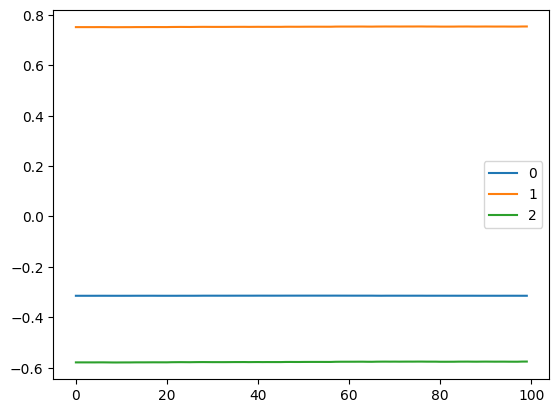

In [147]:
pd.DataFrame(betas_pca).plot()

In [139]:
betas_pca

{0: array([[-0.31466727, -0.54142962, -0.77963996],
        [ 0.74947591, -0.6457432 ,  0.14595065],
        [-0.5824692 , -0.53839548,  0.60898271]]),
 1: array([[-0.31465944, -0.54143591, -0.77963876],
        [ 0.74948888, -0.64572867,  0.14594829],
        [-0.58245674, -0.53840657,  0.60898482]]),
 2: array([[-0.31468473, -0.54145988, -0.7796119 ],
        [ 0.74948753, -0.64572981,  0.14595019],
        [-0.58244482, -0.5383811 ,  0.60901874]]),
 3: array([[-0.31463132, -0.54158023, -0.77954986],
        [ 0.74914955, -0.64601014,  0.146444  ],
        [-0.58290829, -0.53792356,  0.60897961]]),
 4: array([[-0.31461333, -0.54160819, -0.7795377 ],
        [ 0.74907937, -0.64606652,  0.14655425],
        [-0.58300819, -0.53782769,  0.60896866]]),
 5: array([[-0.31471581, -0.54153865, -0.77954464],
        [ 0.74911672, -0.64606289,  0.14637924],
        [-0.58290488, -0.53790206,  0.60900187]]),
 6: array([[-0.31469358, -0.54156423, -0.77953584],
        [ 0.74908238, -0.64608592,  

In [126]:
pcs_by_svd[i]

(array([[-0.27324196,  0.47179896,  0.01482733],
        [-0.29737161,  0.47612882,  0.06349155],
        [-0.28338437,  0.48277842,  0.03971921],
        ...,
        [-0.26493715,  0.4810714 ,  0.02960423],
        [-0.26537483,  0.47648515,  0.02703101],
        [-0.31678352,  0.47765438,  0.1011124 ]]),
 array([[0.00050323, 0.00047224, 0.00077542],
        [0.00047224, 0.00110012, 0.0013103 ],
        [0.00077542, 0.0013103 , 0.00203902]]),
 array([[1.        , 0.63468737, 0.76548984],
        [0.63468737, 1.        , 0.87486425],
        [0.76548984, 0.87486425, 1.        ]]),
 array([0.00325932, 0.00025039, 0.00013266]),
 array([[ 0.31237119,  0.54183236,  0.78028324],
        [-0.74581753,  0.64861706, -0.15182922],
        [-0.58837101, -0.53452185,  0.60671736]]),
 array([0.895, 0.069, 0.036]))

In [133]:
# plot only first components


for i in np.arange(0, 100):
    pc_svd = pcs_by_svd[i][0]
    pc_pca = pcs_by_pca[i][0]
    model0 = LinearRegression(fit_intercept=True).fit(pc_svd, data)
    model1 = LinearRegression(fit_intercept=True).fit(pc_pca, data)
    betas_svd[i, :] = model0.coef_
    betas_pca[i, :] = model1.coef_
    

ValueError: Found input variables with inconsistent numbers of samples: [4004, 6003]

In [111]:
pcs_by_svd

,0,1,2,3,4,5
0,"[[-0.2796256133366959, 0.4679055836328581, 0.0...","[[0.0005043304415711911, 0.0004691681341790137...","[[1.0000000000000002, 0.6310312800208905, 0.76...","[0.0032093263373823362, 0.00025205412325322494...","[[0.31418570510691823, 0.5453807606156482, 0.7...","[0.893, 0.07, 0.037]"
1,"[[-0.27930272645574944, 0.4681083476230823, 0....","[[0.000504078789243597, 0.000468933316969009, ...","[[1.0, 0.6310155255952375, 0.7624857830703111]...","[0.0032078306277136415, 0.0002519808424730513,...","[[0.3141759779759591, 0.5453374152080245, 0.77...","[0.893, 0.07, 0.037]"
2,"[[-0.27933340958854813, 0.4680929210348736, 0....","[[0.0005039845643675103, 0.0004691543634049655...","[[0.9999999999999999, 0.6311501649652439, 0.76...","[0.0032094954996761756, 0.0002519123888328003,...","[[0.31407114944693615, 0.5454362261546468, 0.7...","[0.893, 0.07, 0.037]"
3,"[[-0.27926313520569873, 0.4681341824262132, 0....","[[0.0005040962197290979, 0.0004693230747824849...","[[1.0, 0.6313359719489684, 0.7627305929856519]...","[0.0032102544761729865, 0.0002518304628016519,...","[[0.31413423464663226, 0.5453489967649741, 0.7...","[0.893, 0.07, 0.037]"
4,"[[-0.2792749436341439, 0.4681267426190486, 0.0...","[[0.0005038524455085498, 0.0004690898119680291...","[[1.0000000000000002, 0.6313321068766867, 0.76...","[0.003208655000781238, 0.00025170816885361003,...","[[0.3141344377005794, 0.5453489998401321, 0.77...","[0.893, 0.07, 0.037]"
...,...,...,...,...,...,...
1995,"[[-0.2732566738258412, 0.4717914559704424, 0.0...","[[0.0005031641547591715, 0.0004720179916073823...","[[1.0000000000000002, 0.6344073141046523, 0.76...","[0.0032589979400899157, 0.000250559788388756, ...","[[0.31228740399689947, 0.5418554170376167, 0.7...","[0.895, 0.069, 0.036]"
1996,"[[-0.2732772155671306, 0.47178079926454974, 0....","[[0.000503156589528478, 0.0004722174933168093,...","[[1.0000000000000002, 0.6345137126824575, 0.76...","[0.0032604119613424474, 0.00025052603929914965...","[[0.31222663081810675, 0.5419120852893983, 0.7...","[0.895, 0.069, 0.036]"
1997,"[[-0.2733394213227964, 0.47174259796522927, 0....","[[0.0005032376569570841, 0.0004722995042290536...","[[0.9999999999999998, 0.6345963410666896, 0.76...","[0.003260213997464304, 0.000250481059482042, 0...","[[0.31228023691200135, 0.5419147967483502, 0.7...","[0.895, 0.069, 0.036]"
1998,"[[-0.2732960347925986, 0.4717687722887905, 0.0...","[[0.0005031120225951797, 0.00047218251633171, ...","[[1.0000000000000002, 0.6345954264531575, 0.76...","[0.003259410652553016, 0.0002504247269491333, ...","[[0.31227875605043964, 0.5419097066873567, 0.7...","[0.895, 0.069, 0.036]"


In [ ]:
model0 = LinearRegression(fit_intercept=True)
res0 = model0.fit(X0, data)
model1 = LinearRegression(fit_intercept=True).fit(X1, data)
res1 = model1.fit(X1, data)

In [ ]:
model0.score(X0, data)

In [ ]:
model1.score(X1, data)

In [ ]:
err0 = data - model0.predict(X0)
err1 = data - model1.predict(X1)

In [ ]:
err0

In [ ]:
err1

In [ ]:
sns.displot(data=err0, kind="kde", rug=True)

In [ ]:
sns.displot(data=err1, kind="kde", rug=True)

In [ ]:
# Comparison with Ledoit-Wolf
cov_lw = LedoitWolf().fit(data).covariance_

In [ ]:
_, s2, v2 = svd(cov_lw)
cov2 = np.linalg.multi_dot([v2.T, np.diag(s2), v2])
pc2 = data.dot(v2)
d = np.diag(1 / np.sqrt(np.diag(cov2)))
corr2 = d @ cov2 @ d
X2 = pc2[:, :2]

In [ ]:
exp2 = np.round(s2/sum(s2), 3)
exp2

In [ ]:
model2 = LinearRegression(fit_intercept=True).fit(X2, data)
res2 = model2.fit(X2, data)

In [ ]:
model2.score(X2, data)

In [ ]:
n_trials = 5000
n_data = 2000
distance_lw = []
cov_gen = []
for i in range(trials):
    #     data_tdist = stats.multivariate_t.rvs(loc=mu, shape=s, df=df, size=1000)
    data = stats.multivariate_normal.rvs(mean=mu, cov=s, size=n_data)
    cov_lw = LedoitWolf().fit(data).covariance_
    cov_gen.append(cov_lw)
    mae = np.sum(np.abs((cov_lw - s) / s))
    distance_lw.append(mae)

In [ ]:
plt.plot(np.sort(distance_mle), label='MLE')
plt.plot(np.sort(distance_lw), label='LW')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.hist(distance_mle,cumulative=True, label='mle',
         histtype='step', alpha=0.8)
plt.hist(distance_lw,cumulative=True, label='lw',
         histtype='step', alpha=0.8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Stability of the two PCA approaches:
